# Setting Pyspark

In [40]:
import findspark
import numpy as np
import pandas as pd
import seaborn as sns   
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pyspark.sql.types as T

from scipy import stats
from configs.config import DATA_SOURCE_DIR
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as _sum, expr, col as pyspark_col

In [24]:
findspark.init()
findspark.find()

spark= SparkSession \
       .builder \
       .appName("EDA from data source (PostgresQL)") \
       .getOrCreate()

In [25]:
df = spark.read.csv(str(DATA_SOURCE_DIR),header=True,escape="\"")

In [26]:
df.show(5,0)

+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------+-------------+-------------------+--------------------------+------------+------------------------------+-----------+
|person_age|person_gender|person_education|person_income|person_emp_exp|person_home_ownership|loan_amnt|loan_intent|loan_int_rate|loan_percent_income|cb_person_cred_hist_length|credit_score|previous_loan_defaults_on_file|loan_status|
+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------+-------------+-------------------+--------------------------+------------+------------------------------+-----------+
|22.0      |female       |Master          |71948.0      |0             |RENT                 |35000.0  |PERSONAL   |16.02        |0.49               |3.0                       |561         |No                            |1          |
|21.0      |female       |High School     |12282.0      |0      

# Counting number of rows 

In [27]:
# Số dòng trong dataset
total_rows = df.count()
print(f"Total number of records in the dataset: {total_rows}")

Total number of records in the dataset: 45000


# Check dataset information

In [28]:
df.printSchema() # Use printSchema() to get schema information
df.summary().show() # Use summary() and show() for descriptive statistics

root
 |-- person_age: string (nullable = true)
 |-- person_gender: string (nullable = true)
 |-- person_education: string (nullable = true)
 |-- person_income: string (nullable = true)
 |-- person_emp_exp: string (nullable = true)
 |-- person_home_ownership: string (nullable = true)
 |-- loan_amnt: string (nullable = true)
 |-- loan_intent: string (nullable = true)
 |-- loan_int_rate: string (nullable = true)
 |-- loan_percent_income: string (nullable = true)
 |-- cb_person_cred_hist_length: string (nullable = true)
 |-- credit_score: string (nullable = true)
 |-- previous_loan_defaults_on_file: string (nullable = true)
 |-- loan_status: string (nullable = true)



+-------+-----------------+-------------+----------------+-----------------+-----------------+---------------------+-----------------+-----------------+------------------+-------------------+--------------------------+-----------------+------------------------------+------------------+
|summary|       person_age|person_gender|person_education|    person_income|   person_emp_exp|person_home_ownership|        loan_amnt|      loan_intent|     loan_int_rate|loan_percent_income|cb_person_cred_hist_length|     credit_score|previous_loan_defaults_on_file|       loan_status|
+-------+-----------------+-------------+----------------+-----------------+-----------------+---------------------+-----------------+-----------------+------------------+-------------------+--------------------------+-----------------+------------------------------+------------------+
|  count|            45000|        45000|           45000|            45000|            45000|                45000|            45000|     

# Checking Null Values #
+ For each column in the dataframe, check if each value is null using isNull().
+ Convert the results (True/False) to integers (1/0) using cast("int").
+ Sum these integer values for each column using _sum to get the total null count per column.
+ Display the null counts for each column using show().

In [29]:
# Count null values for each column
null_counts = df.select([((pyspark_col(column).isNull()).cast("int")).alias(column) for column in df.columns])

# Aggregate the null counts and display
# Use PySpark's sum function (renamed to _sum) for aggregation
null_counts_summary = null_counts.agg(*[_sum(pyspark_col(column)).alias(column) for column in null_counts.columns])

# Show the count of null values for each column
null_counts_summary.show()

+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------+-------------+-------------------+--------------------------+------------+------------------------------+-----------+
|person_age|person_gender|person_education|person_income|person_emp_exp|person_home_ownership|loan_amnt|loan_intent|loan_int_rate|loan_percent_income|cb_person_cred_hist_length|credit_score|previous_loan_defaults_on_file|loan_status|
+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------+-------------+-------------------+--------------------------+------------+------------------------------+-----------+
|         0|            0|               0|            0|             0|                    0|        0|          0|            0|                  0|                         0|           0|                             0|          0|
+----------+-------------+----------------+-------------+-------

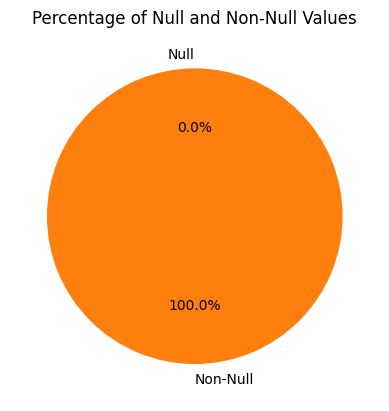

In [30]:
# ... (previous code to calculate null_counts_summary) ...

# Collect the null counts data into a Python list
null_counts_data = null_counts_summary.collect()[0].asDict()

# Calculate total values for each column
total_values = df.count()

# Prepare data for pie chart
labels = ['Null', 'Non-Null']
sizes = [sum(null_counts_data.values()), total_values * len(df.columns) - sum(null_counts_data.values())]
# Total non-null values = Total values - Total null values

# Create and display the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Null and Non-Null Values')
plt.show()

**Comment:** Clean data

# Check distribution #
1. Select numerical columns: Identify the columns that contain numerical data (like age, income, credit score, etc.).
2. Create histograms: Generate a histogram plot for each numerical column. Histograms are like bar charts showing the frequency of different values.
3. Observe: Analyze the shape of the histograms to understand the data distribution:
   *   If the histogram is high in the middle and tapers off on both sides, the data is evenly distributed.
   *   If the histogram is skewed to one side, the data has a skewed distribution.
   *   If there are unusually high bars far from the center, there might be outliers.

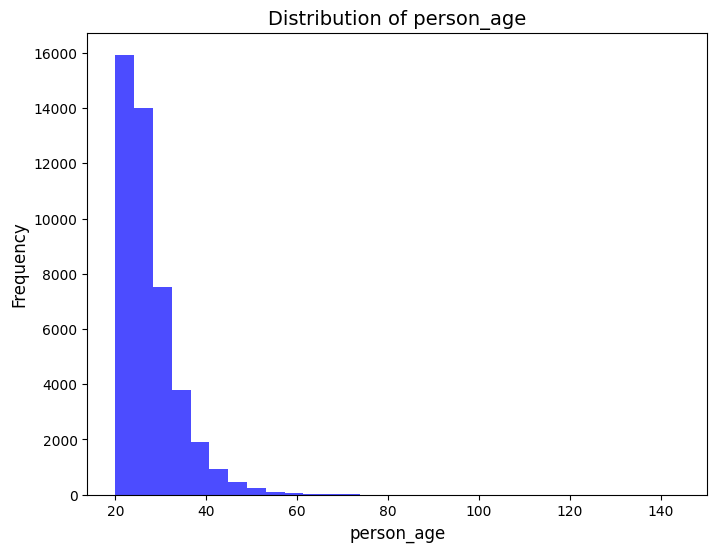

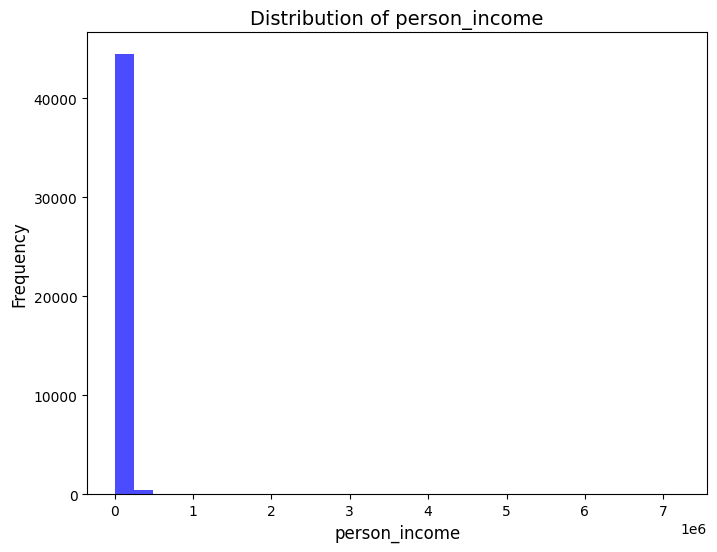

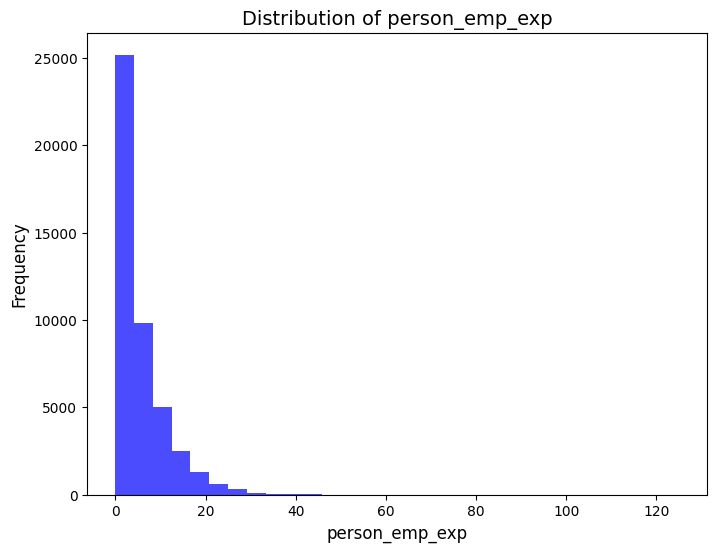

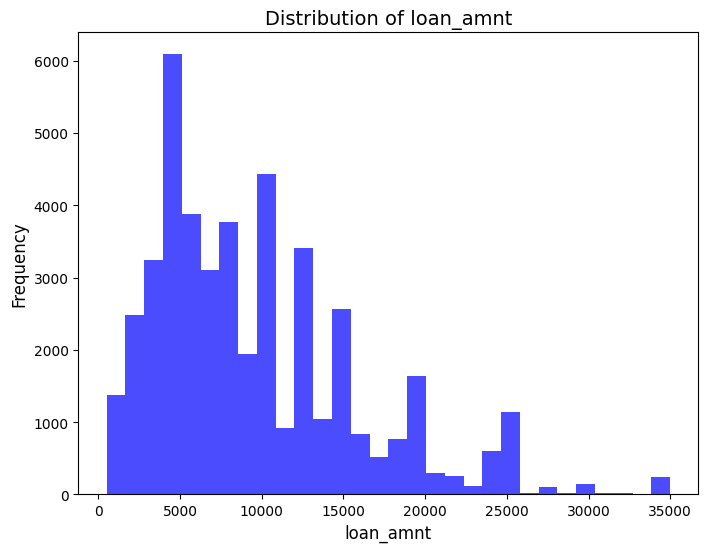

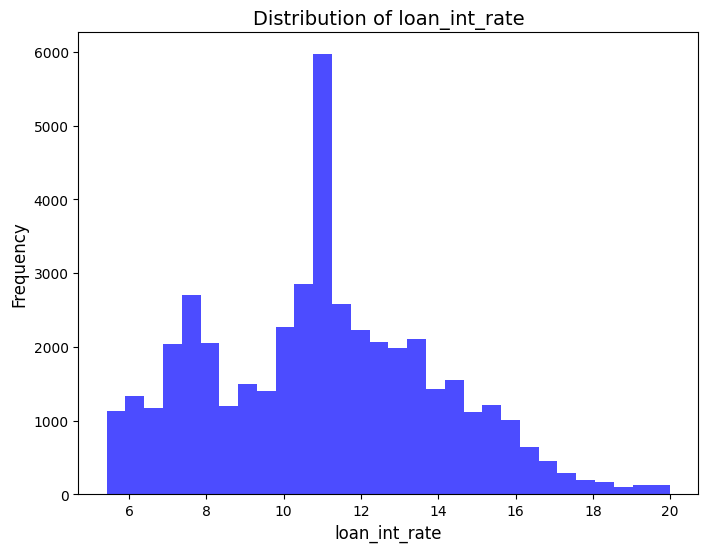

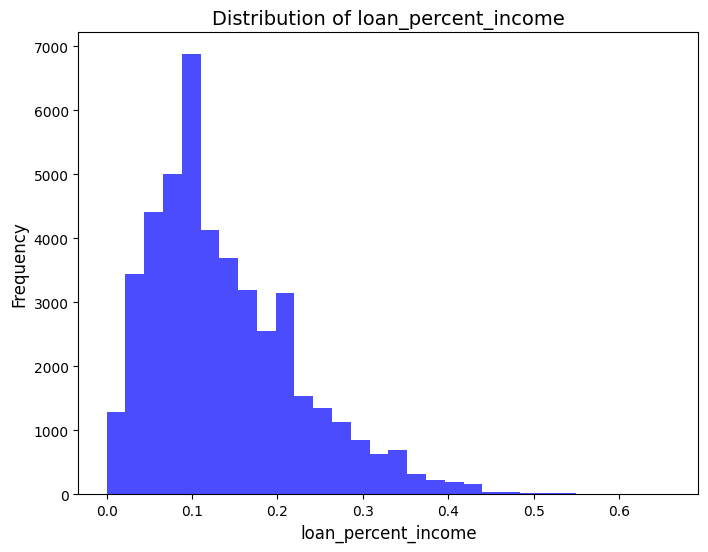

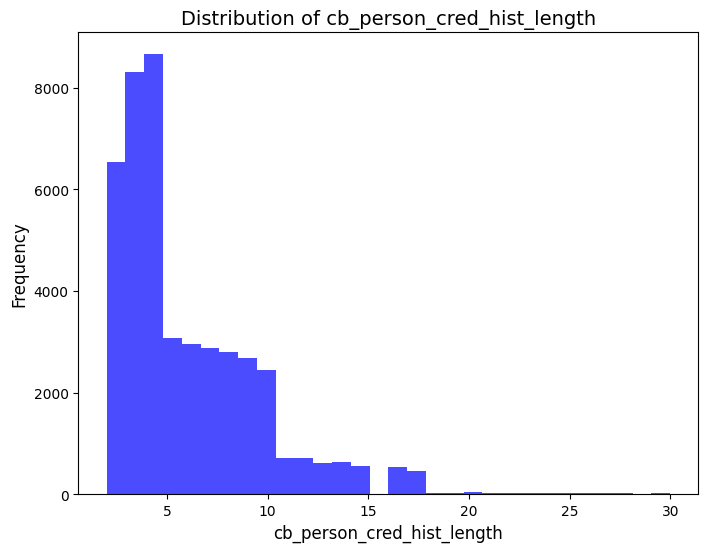

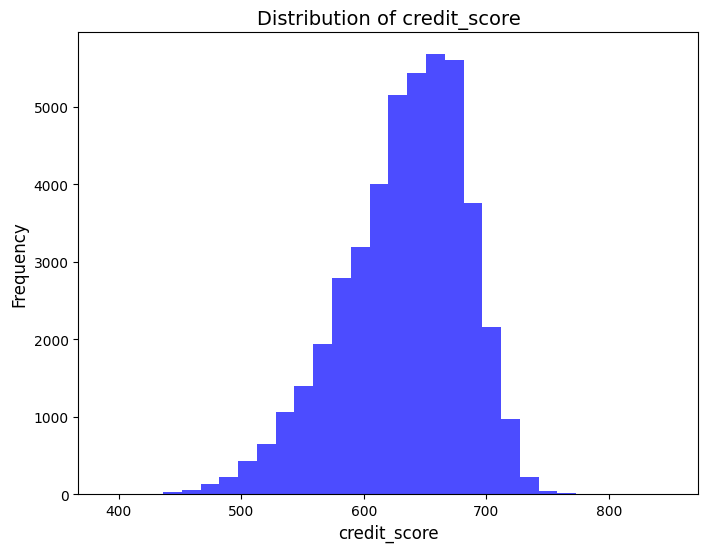

In [31]:
# Các cột cần chuyển đổi sang số
numerical_columns = [
    'person_age',
    'person_income',
    'person_emp_exp',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length',
    'credit_score'
]

# Chuyển đổi các cột sang kiểu float, xử lý lỗi nếu có giá trị không hợp lệ
for col in numerical_columns:
    if col in df.columns:
        # Use PySpark's cast function to convert the column type
        df = df.withColumn(col, pyspark_col(col).cast(T.FloatType()))

# Loại bỏ các cột không hợp lệ hoặc không thể chuyển đổi
numerical_columns = [col for col in numerical_columns if col in df.columns]

# Vẽ biểu đồ phân phối (histogram) cho từng cột số
for col_name in numerical_columns:
    plt.figure(figsize=(8, 6))
    # Convert the PySpark DataFrame column to a pandas Series for plotting
    pd_series = df.select(col_name).toPandas()[col_name]
    pd_series.dropna().hist(bins=30, grid=False, color='blue', alpha=0.7)
    plt.title(f'Distribution of {col_name}', fontsize=14)
    plt.xlabel(col_name, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(False)
    plt.show()

**Comment For Distribution of**

**person_age diagram:**


- The chart shows that the data in the `person_age` column does not follow a normal distribution but is skewed to the right.  
- Most values are concentrated between 20 and 40 years old.
- The most common values are between 20 and 25 years old, with the frequency peaking at approximately 16,000.

**person_emp_exp diagram:**

- The chart shows that the data in the `person_emp_exp` column does not follow a normal distribution but is skewed to the right.

- Most values are concentrated at 0 and gradually decrease until 10

**loan_amnt:**

- The distribution is slightly skewed to the right.

- The loan values are mainly concentrated in the range of 5,000 to 15,000.

**loan_int_rate:**

- The data in the `loan_int_rate` column is almost bell-shaped but does not completely follow a normal distribution (slightly skewed to the right).  

- Most interest rate values fall within the range of 10% to 14%.

**loan_percent_income:**

- The data in the `loan_percent_income` column (loan-to-income ratio) is skewed to the right.  
- Most values are concentrated in the range of 0.1 to 0.2.  
- The most common value is around 0.1, with the highest frequency (~7,000).

**cb_person_cred_hist_length:**

- The data in the cb_person_cred_hist_length column (credit history length of the borrower) is skewed to the right.
- Most values are concentrated in the range of 5 to 10 years.
- The most common value is around 6 years, with the highest frequency of approximately 9,000.

**credit_score:**

- The data in the `credit_score` column (credit score) closely follows a normal distribution.  
- Credit scores are primarily concentrated in the range of 550 to 700.  
- The most common value (highest frequency) is around 650, with the peak frequency at approximately 5,500.

# Check outliner (IQR) #

We will use the IQR method to determine the outliner values for the dataset

**Steps to Detect Outliers Using IQR:**
1. Calculate Q1 and Q3:
    --> Quantile(Q): Divide data into equal parts after sorting from smallest to largest.
*   Q1 (First Quartile): The value below which 25% of the data falls.
*   Q3 (Third Quartile): The value below which 75% of the data falls.
2. Calculate IQR:
*   IQR= Q3 − Q1
*   IQR represents the spread of the middle 50% of the data.
3. Define Outlier Bounds:
*   Lower Bound: Q1−1.5×IQR
*   Upper Bound: Q3+1.5×IQR
*   Any data point below the lower bound or above the upper bound is considered an outlier.
(hoc lai)

In [32]:
# Danh sách các cột cần chuyển đổi thành số
numerical_columns = [
    'person_age',
    'person_income',
    'person_emp_exp',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length',
    'credit_score'
]

numerical_columns = [col for col in numerical_columns if col in df.columns]

# Chuyển đổi các cột sang kiểu float, xử lý lỗi nếu có giá trị không hợp lệ
for col in numerical_columns:
    if col in df.columns:
        # Use PySpark's cast function to convert the column type
        df = df.withColumn(col, F.col(col).cast(T.FloatType()))

# Hàm kiểm tra giá trị ngoại lai bằng IQR
def detect_outliers_iqr(data, column):
    # Tính toán Q1 và Q3
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1

    # Xác định ngưỡng
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Lọc giá trị ngoại lai
    outliers = df.filter((pyspark_col(column) < lower_bound) | (pyspark_col(column) > upper_bound))


    return {
        "column": column,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
        "outlier_count": outliers.count(),
        "outliers_df": outliers
    }
# Áp dụng kiểm tra ngoại lai cho từng cột số
outlier_results = []
for col in numerical_columns:
    if col in df.columns:
        result = detect_outliers_iqr(df, col)
        outlier_results.append(result)

# Hiển thị kết quả
for result in outlier_results:
    print(f"Column: {result['column']}")
    print(f"  Lower Bound: {result['lower_bound']}")
    print(f"  Upper Bound: {result['upper_bound']}")
    print(f"  Outlier Count: {result['outlier_count']}")
    print(f"  Outliers:\n{result['outliers_df'].head()}")
    print("-" * 50)


Column: person_age
  Lower Bound: 15.0
  Upper Bound: 39.0
  Outlier Count: 2188
  Outliers:
Row(person_age=144.0, person_gender='male', person_education='Bachelor', person_income=300616.0, person_emp_exp=125.0, person_home_ownership='RENT', loan_amnt=4800.0, loan_intent='VENTURE', loan_int_rate=13.569999694824219, loan_percent_income=0.019999999552965164, cb_person_cred_hist_length=3.0, credit_score=789.0, previous_loan_defaults_on_file='No', loan_status='0')
--------------------------------------------------
Column: person_income
  Lower Bound: -25496.0
  Upper Bound: 166792.0
  Outlier Count: 2248
  Outliers:
Row(person_age=23.0, person_gender='female', person_education='Master', person_income=600891.0, person_emp_exp=5.0, person_home_ownership='MORTGAGE', loan_amnt=30000.0, loan_intent='DEBTCONSOLIDATION', loan_int_rate=10.649999618530273, loan_percent_income=0.05000000074505806, cb_person_cred_hist_length=3.0, credit_score=670.0, previous_loan_defaults_on_file='Yes', loan_status='

In [34]:
# Áp dụng kiểm tra ngoại lai cho từng cột số
outlier_results = []
for col in numerical_columns:
    if col in df.columns:
        result = detect_outliers_iqr(df, col)
        outlier_results.append(result)

# Hiển thị kết quả dưới dạng bảng
outlier_df = pd.DataFrame(outlier_results)  # Create a pandas DataFrame
# Select relevant columns for the table
outlier_table = outlier_df[['column', 'lower_bound', 'upper_bound', 'outlier_count']]
display(outlier_table)  # Display the table using display

,column,lower_bound,upper_bound,outlier_count
0,person_age,15.00,39.00,2188
1,person_income,-25496.00,166792.00,2248
2,person_emp_exp,-9.50,18.50,1724
3,loan_amnt,-5500.00,22500.00,2425
4,loan_int_rate,1.74,19.74,104
5,loan_percent_income,-0.11,0.37,898
6,cb_person_cred_hist_length,-4.50,15.50,1366
7,credit_score,496.50,772.50,455


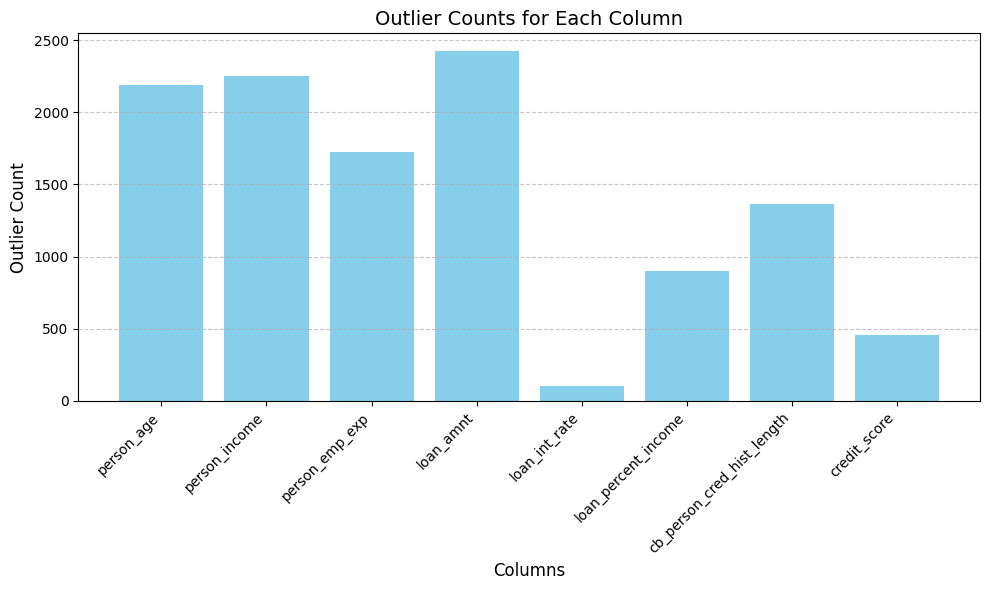

In [35]:
columns = [res["column"] for res in outlier_results]
outlier_counts = [res["outlier_count"] for res in outlier_results]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(columns, outlier_counts, color='skyblue')
plt.title("Outlier Counts for Each Column", fontsize=14)
plt.xlabel("Columns", fontsize=12)
plt.ylabel("Outlier Count", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

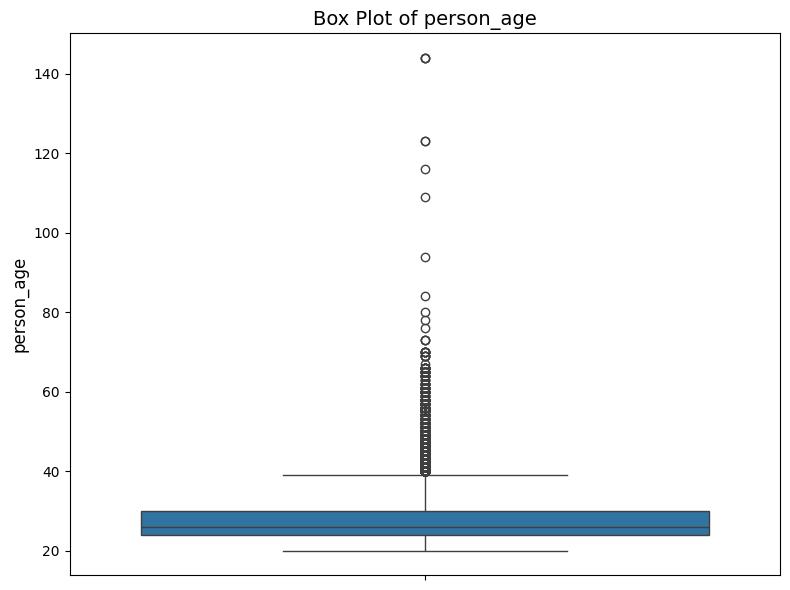

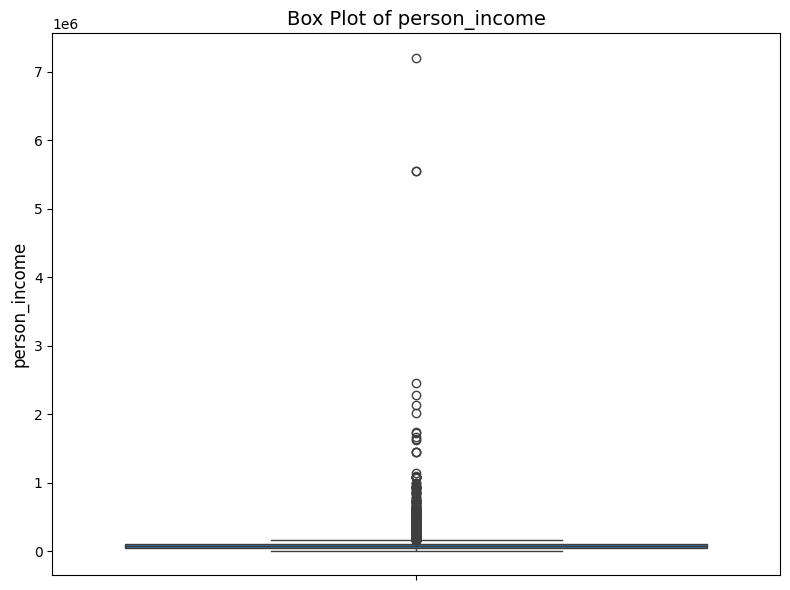

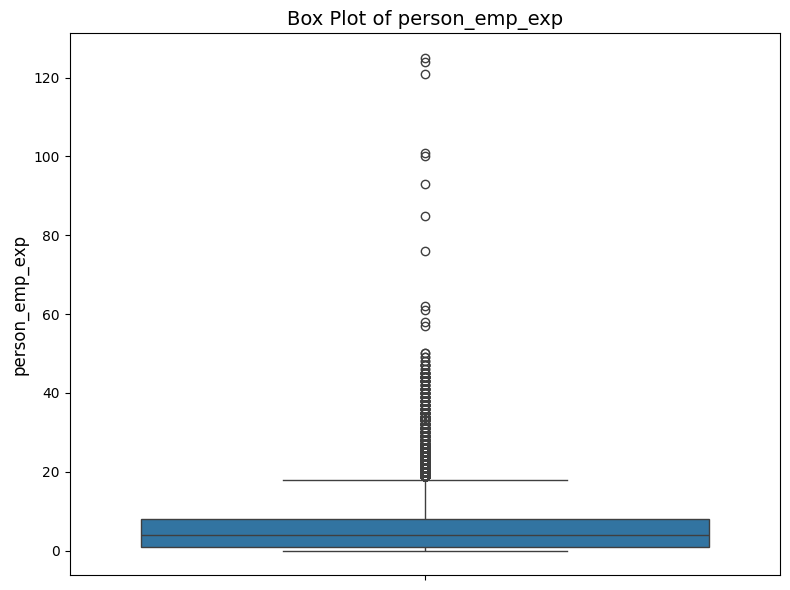

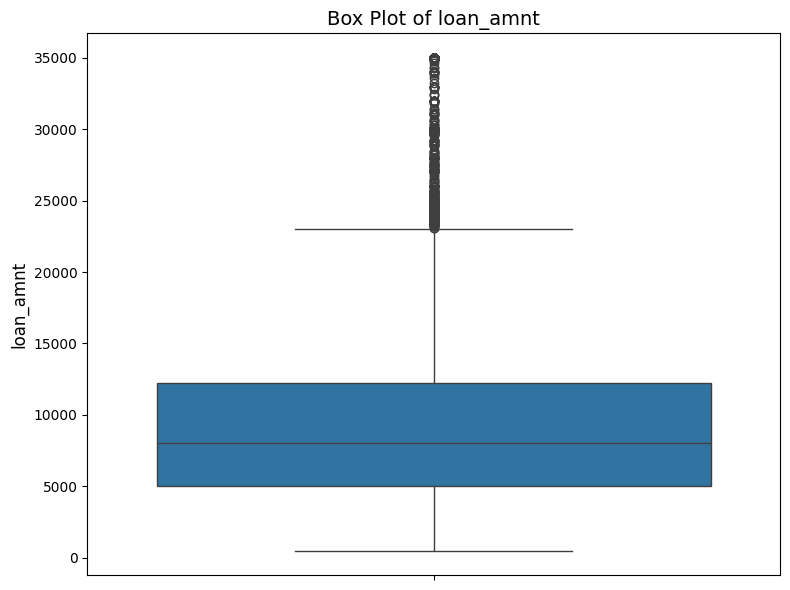

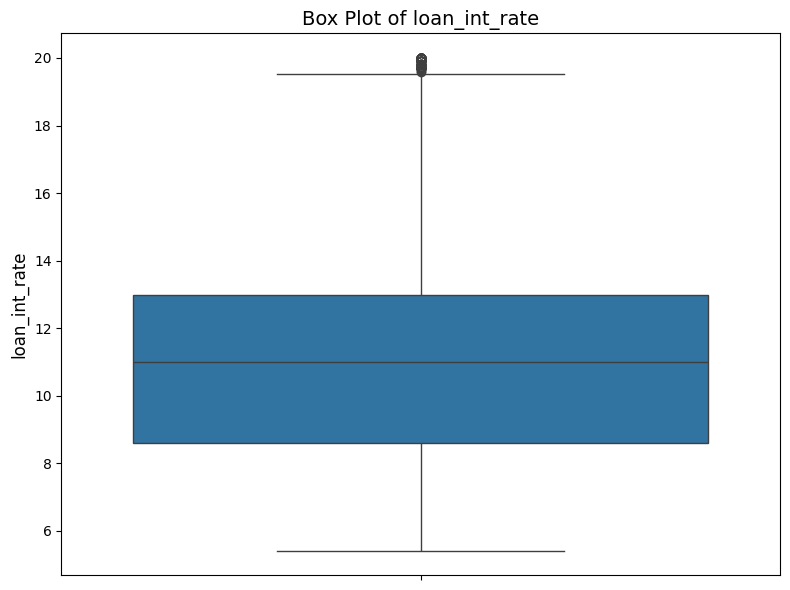

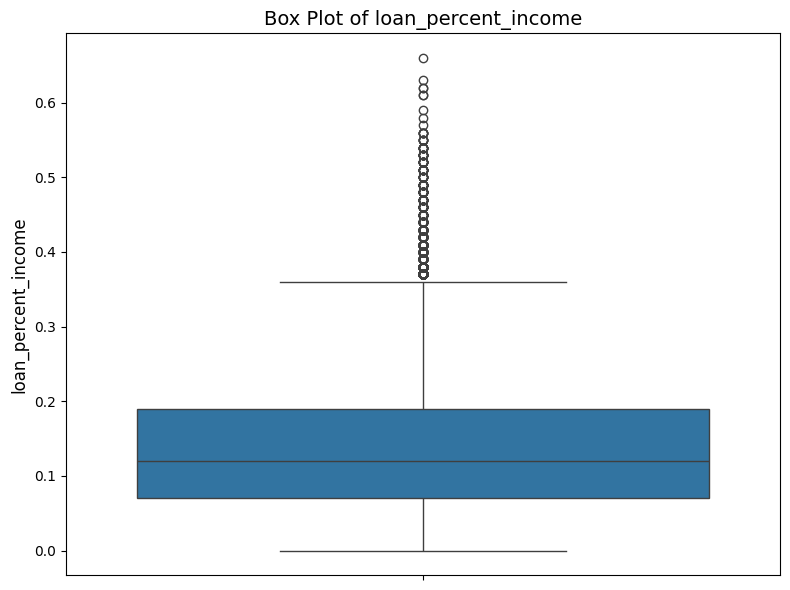

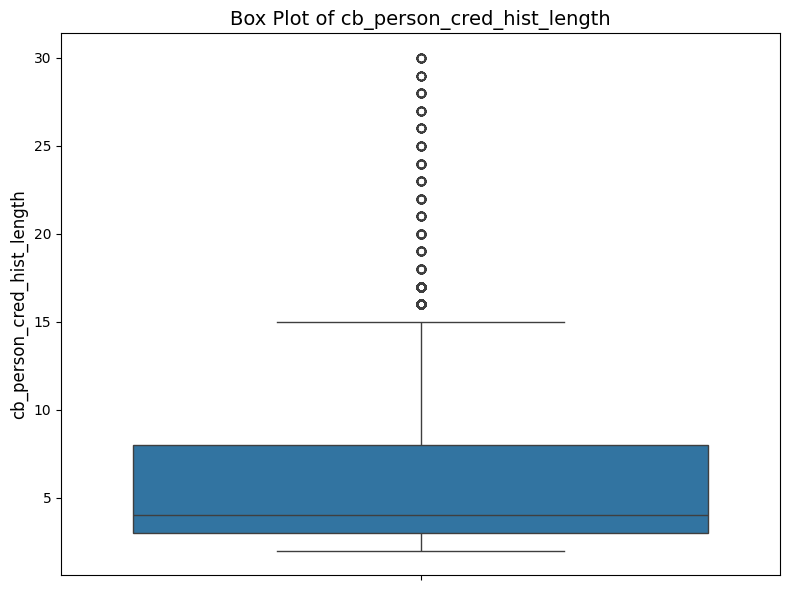

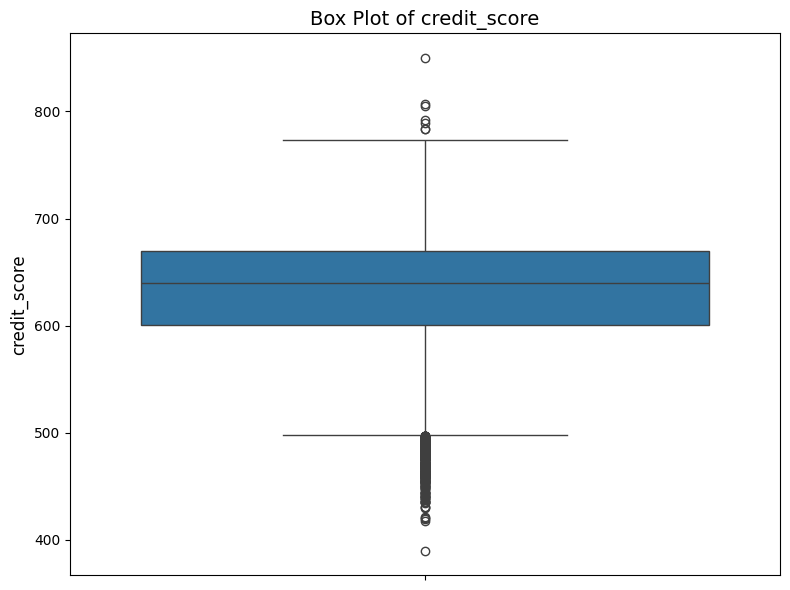

In [37]:
# Assuming 'df' is your PySpark DataFrame and 'numerical_columns' is your list of numerical columns

for col in numerical_columns:
    # Convert the PySpark DataFrame column to a pandas Series for plotting
    pd_series = df.select(col).toPandas()[col]

    plt.figure(figsize=(8, 6))  # Create a separate figure for each plot
    sns.boxplot(y=pd_series)  # Create the box plot using seaborn
    plt.title(f"Box Plot of {col}", fontsize=14)
    plt.ylabel(col, fontsize=12)
    plt.tight_layout()
    plt.show()

**Comments:**
- The chart shows the number of outliers (`outlier_count`) for each numerical column.
- **Columns with the most outliers:**
  - `loan_amnt` (~2,425 values): This column has the highest number of outliers, likely due to loans that are either too small or too large compared to typical ranges.
  - `person_income` (~2,248 values): A significant number of outliers, possibly caused by extremely low (negative) or very high income values.
  - `person_age` (~2,188 values): Many outliers, likely related to unreasonable age values (e.g., below 15 or above 39).
- **Columns with the least outliers:**
  - `loan_int_rate` (~104 values): Only a few interest rates fall outside the typical range (1.74% - 19.74%).
  - `credit_score` (~455 values): The credit score has fewer outliers compared to other columns.


# Check Duplication #

In [38]:
# Kiểm tra các dòng bị trùng lặp
duplicate_rows = df.groupBy(df.columns).count().filter("count > 1")
# Hiển thị số lượng dòng trùng lặp
print(f"Duplicate records: {duplicate_rows.count()}")

# Nếu muốn hiển thị các dòng bị trùng lặp
if duplicate_rows.count() > 0:
    print("Duplicate rows:")
    duplicate_rows.show()

Duplicate records: 0


**Comment**: There are no duplicated samples in the dataset

# Check class imbalance #

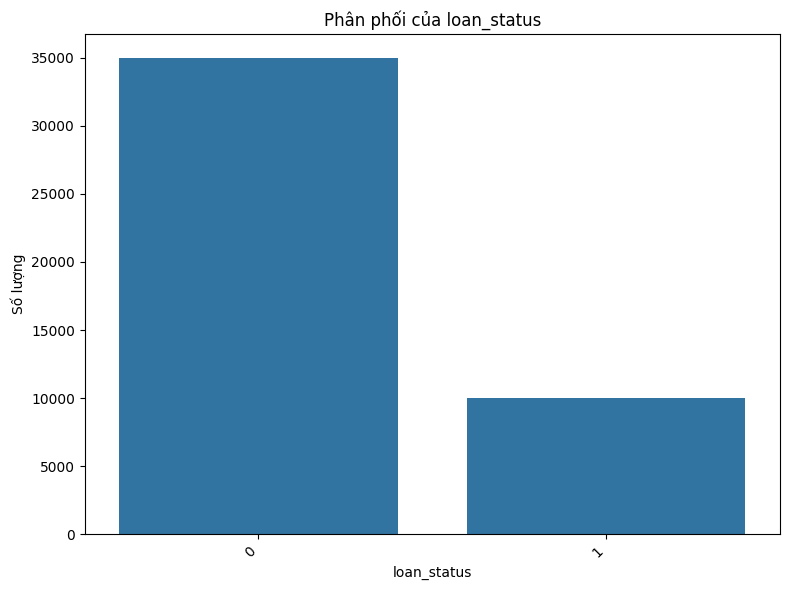

In [39]:
columns_all = df.columns
column = columns_all[-1]

pandas_series = df.select(column).toPandas()[column]
column_type = df.schema[column].dataType

if isinstance(column_type, T.NumericType):
    # Vẽ histogram cho cột số
    plt.figure(figsize=(8, 6))
    sns.histplot(pandas_series, bins=30)  # Sử dụng histplot cho cột số
    plt.title(f'Phân phối của {column}')
    plt.xlabel(column)
    plt.ylabel('Tần suất')
else:
    # Đếm các giá trị giống nhau cho cột phân loại
    value_counts = pandas_series.value_counts()

    # Vẽ biểu đồ bar cho cột phân loại
    plt.figure(figsize=(8, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Phân phối của {column}')
    plt.xlabel(column)
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Comment**: The class is **significantly imbalance**. While class 0 has around 35000 records, class 1 has only 10000 samples

# Check correlation

**About Cramer:**
  *  What is Cramér V method:
     - Cramér's V is a way to measure the degree of association between two categorical variables.
     - This is a variation of the Chi-Square test
  *  Chi-Square test:
     - Frequency tables help you check whether two categorical variables are related to each other
     - How to calculate Chi-Square value:
       + Build a frequency table
       + Calculate expected frequency data:
              Expected frequency (E) = (Total number of rows * Total number of columns)/Total number of observations
       + Calculate the Chi-Square value:
              X^2 = ∑((O - E)^2/E)
         -> In there:
              + O is the actual value
              + E is the expected value
  * Steps to calculate Cramér's V:
    - Build a frequency table
    - Count Chi-Square
    - Count Cramér's V
    
$V = \sqrt{\frac{\chi^2}{n \cdot \min(k-1, r-1)}}$

In [41]:
# Function for calculating Cramer's V
def cramers_v(confusion_matrix):
    """Calculating Cramer's V coefficient from contingency table."""
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    k = min(confusion_matrix.shape)  # Số hàng hoặc cột nhỏ hơn
    return np.sqrt(chi2 / (n * (k - 1)))

# Create Cramer's V matrix for all features
def cramers_v_matrix(data, categorical_columns):
    """Create Cramer's V matrix for all features."""
    matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 == col2:
                matrix.loc[col1, col2] = 1.0 # The correlation in diagonal is 1.0
            else:
                confusion_matrix = pd.crosstab(data[col1], data[col2])
                # Ensure cramers_v returns a single value
                cramers_value = cramers_v(confusion_matrix.to_numpy())
                matrix.loc[col1, col2] = cramers_value
    return matrix.astype(float)

In [43]:
all_columns = [
    f.name for f in df.schema.fields if isinstance(f.dataType, (T.StringType, T.DateType, T.NumericType))  # Updated
]

cramers_matrix1 = cramers_v_matrix(df.toPandas(), all_columns[:-1])  # Updated

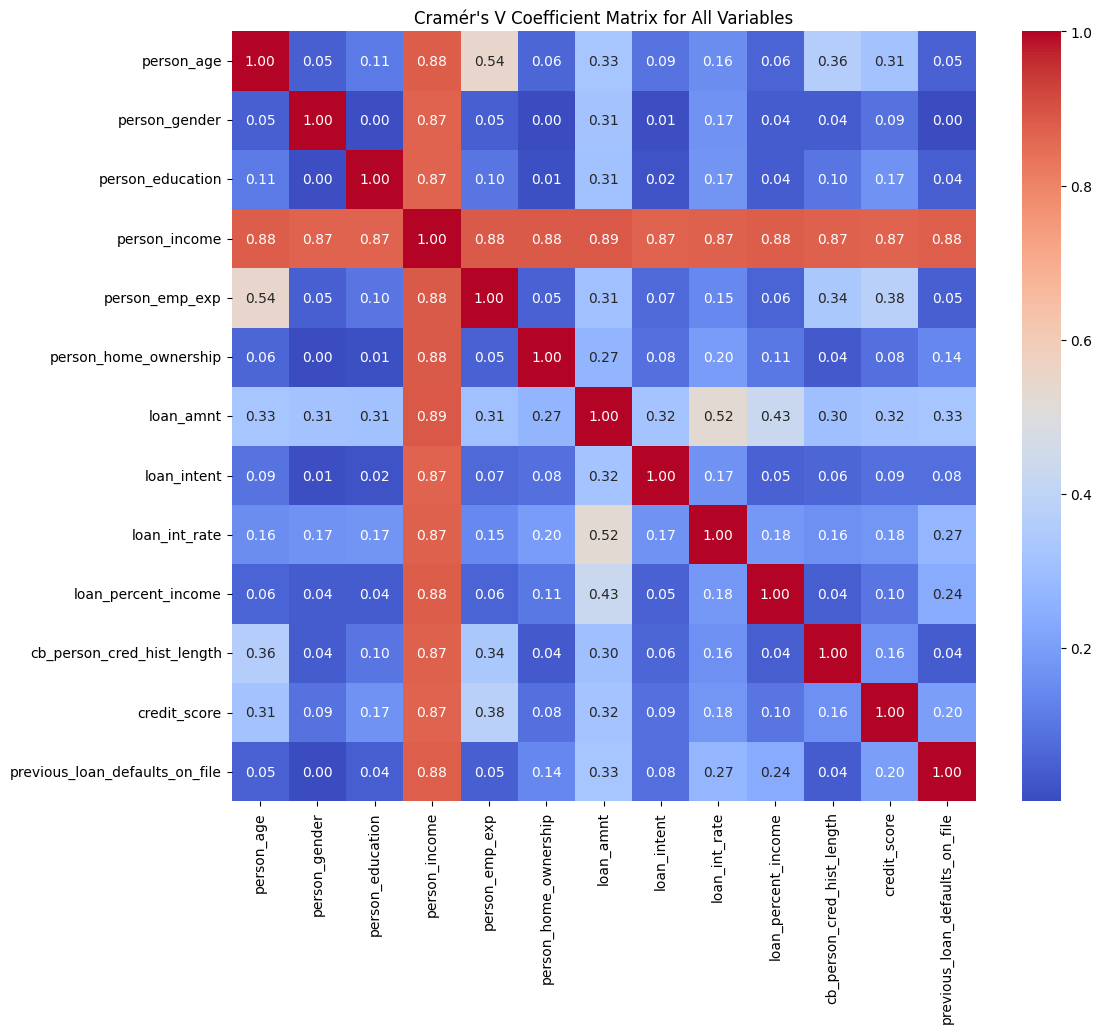

In [44]:
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_matrix1, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Cramér's V Coefficient Matrix for All Variables")
plt.show()

**Comment:**
  *  General:
     + The coefficient ranges from 0 (no relationship) to 1 (match).
     + Color:
        - Red (from light to dark): The relationship is getting closer.
        - Navy blue (from light to dark): The relationship is weakening.
  * Comments for relationships:
   + Strong relationships: *Personal income is the central factor*
     - person_income: with most other columns (0.8 - 0.9)   
     - Income depends on age, experience or gender
     - Loans, interest rates and affordability depend on this factor
   + Moderate relationships:
     - *Person employment experience and person age*
     - *Loan amount and Loan interest rate*